# Understanding Your Customers: A Fresh Take on Analyzing Product Reviews

Aisha Al-Khaldi & Huda Joad

## Where are we in the data science pipeline?

- **Ask an interesting question**
- Get the data
- Explore the data
- Model the data
- Communicate/visualize the results

### Our Question

When customers want to express their thoughts and sentiments about a product, they usually do it through written reviews and assign a rating for their experience (in our case, a boolean of positive/negative). We would like to delve into the discussion of **the relationship between the content of the review and its assigned rating**.

We will be using Steam Web API, and try to perform a sentiment analysis on reviews to answer our question.

## Where are we in the data science pipeline?

- Ask an interesting question
- **Get the data**
- Explore the data
- Model the data
- Communicate/visualize the results

### Data Collection

In [81]:
import requests
import pandas as pd
import time
from requests.exceptions import ConnectionError
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/awashi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/awashi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Steam API

Steam has a web API. This means we don't actually need an API key to extract what we need, which are the reviews for various games. Instead, we can simply use different URLs.

More about Steam's web API can be found [here](https://partner.steamgames.com/doc/store/getreviews).

The web API allows us to filter by positive and negative reviews, which means we can use this to get labeled data without having to do it ourselves. Currently, there are over 1.6 million apps, although all of them do not necessarily have reviews.

In [2]:
url = "https://store.steampowered.com/appreviews/50?json=1&review_type=negative"
r = requests.get(url)
data = r.json()

data

{'success': 1,
 'query_summary': {'num_reviews': 2},
 'reviews': [{'recommendationid': '150673892',
   'author': {'steamid': '76561198355093882',
    'num_games_owned': 31,
    'num_reviews': 16,
    'playtime_forever': 613,
    'playtime_last_two_weeks': 326,
    'playtime_at_review': 541,
    'last_played': 1700853064},
   'language': 'english',
   'review': 'Well and truly, this game is pretty... okay. I say that cause the first half is fun, interesting, you get to see how one of the HECU would deal with the Black Mesa Incident nothing much to complain about there (except for buggy AI, but it\'s a half life 1 game. What else do you expect?).\nThe second half though just feels like its trying to be a harder half life 1. Race X aliens that are just sponges, with you taking insane amounts of damage and wasting a good chunk of ammo on a singular one. They\'re too fast, too spongy and a general nightmare to play against.\nThen you have what can only be described as Gearbox going "hmm wha

In this example we can see we get 2 negative reviews in JSON format. To get the reviews alone, let's try this.

In [3]:
[print(review['review']) for review in data['reviews']]

Well and truly, this game is pretty... okay. I say that cause the first half is fun, interesting, you get to see how one of the HECU would deal with the Black Mesa Incident nothing much to complain about there (except for buggy AI, but it's a half life 1 game. What else do you expect?).
The second half though just feels like its trying to be a harder half life 1. Race X aliens that are just sponges, with you taking insane amounts of damage and wasting a good chunk of ammo on a singular one. They're too fast, too spongy and a general nightmare to play against.
Then you have what can only be described as Gearbox going "hmm what if we made an annoying bit of half life (blast pit) even worse" and also going "what if we made a boss but terrible". It also feels like they were adding filler with how difficult and annoying the game gets.
The entire second half of the game is just not FUN. 

If you want more Half Life 1, get Blue Shift. It's short, but so much better.
The gameplay is great, but

[None, None]

We would know that these are negative reviews as we filtered for negative reviews in the URL for the Steam web API. With all this information, we can now programatically get labeled reviews. For the sake of this project, we will simply a minimum of the first 5,000 positive and negative reviews and go through the apps in order starting from app ID 1.

!!! Do not run the cell below. It was for generating the csv file, and will run for 6+ hours. You can skip this cell as we have already provided the csv for you.

In [4]:
# Function to fetch reviews from Steam API for a given game ID and review type (positive or negative)
def fetch_reviews(game_id, review_type):
    url = f"https://store.steampowered.com/appreviews/{game_id}?json=1&review_type={review_type}"
    try:
        r = requests.get(url)  # Make an HTTP GET request to the API
        if r.status_code == 200:
            data = r.json()  # Parse the JSON response
            return [review['review'] for review in data['reviews']]  # Return a list of reviews
    except ConnectionError:
        print(f"Connection error for game ID {game_id}. Retrying...")
        time.sleep(5)  # Wait for 5 seconds before retrying
        return fetch_reviews(game_id, review_type)  # Recursive retry
    return []  # Return an empty list if the request fails or an exception occurs

# Initialize lists to store positive and negative reviews
positive_reviews = []
negative_reviews = []
game_id = 1  # Start from the first game ID

# Loop until 5000 positive and 5000 negative reviews are collected
while len(positive_reviews) < 5000 or len(negative_reviews) < 5000:
    print(f"Game ID: {game_id}")
    if len(positive_reviews) < 5000:
        # Fetch and add positive reviews for the current game ID
        positive_reviews.extend(fetch_reviews(game_id, 'positive'))
        print(f"    Total Positive Reviews: {len(positive_reviews)}")

    if len(negative_reviews) < 5000:
        # Fetch and add negative reviews for the current game ID
        negative_reviews.extend(fetch_reviews(game_id, 'negative'))
        print(f"    Total Negative Reviews: {len(negative_reviews)}")

    game_id += 1  # Increment the game ID for the next iteration
    time.sleep(0.2)  # Pause for 0.5 seconds to avoid hitting the rate limit

# Combine the positive and negative reviews into a single list with their corresponding sentiment labels
reviews_data = [(review, 'positive') for review in positive_reviews] + \
               [(review, 'negative') for review in negative_reviews]

# Create a DataFrame from the combined review data
df = pd.DataFrame(reviews_data, columns=['review', 'sentiment'])

# Save the DataFrame to a CSV file, without the index and using UTF-8 encoding
df.to_csv('steam_reviews.csv', index=False, encoding='utf-8')

In [4]:
reviews_df = pd.read_csv('steam_reviews.csv', encoding='utf-8')

In [5]:
reviews_df

,review,sentiment
0,if ur tired of cs2 come back to 2000 and play ...,positive
1,Counter-Strike 1.6 was a significant part of m...,positive
2,rather pay for this than winrar,positive
3,Better then CS2,positive
4,"Every school that i have attended, had this in...",positive
...,...,...
9998,Its just a terrible clone of katamari. And IMO...,negative
9999,TL:DR this game was made 12 year old who got a...,negative
10000,Insultingly bad Katamari Damacy rip-off.,negative
10001,The poor man's Katamari Damacy.,negative


In [6]:
reviews_df.sentiment.value_counts()

negative    5003
positive    5000
Name: sentiment, dtype: int64

Now we have 10,003 total reviews from 15,970 apps. Providing an equal number of data for each label is important because ???.

## Where are we in the data science pipeline?

- Ask an interesting question
- Get the data
- **Explore the data**
- Model the data
- Communicate/visualize the results

### Data Processing

Before we dive into the world of sentiment analysis, we first have to process our data using our API. 

In [7]:
reviews_df.isna().sum()

review       5
sentiment    0
dtype: int64

Since we have enough reviews, we can simply drop the rows with null values.

In [8]:
reviews_df.dropna(inplace=True)
reviews_df.isna().sum()

review       0
sentiment    0
dtype: int64

In [9]:
reviews_df.shape

(9998, 2)

### Exploration/Visualization

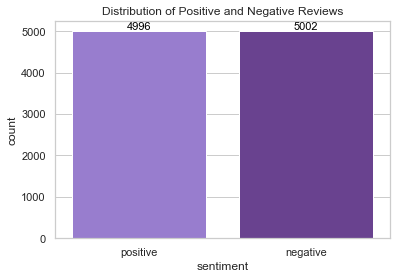

In [77]:
# the distribution of sentiments in the dataset
palette = {"positive": "#9370db", "negative": "#69359c"}
plot = sns.countplot(data=reviews_df, x='sentiment', palette=palette)
plt.title('Distribution of Positive and Negative Reviews')

# using annotations to showcase the exact difference between the two review features
for bar in plot.patches:
    plot.annotate(f'{bar.get_height()}', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

As you can see in the above plot, we found an almost equal number of positive and negative comments: 4,996 positive and 5,002 negative (we provided annotations on the graph for extra clarification due to the small difference between the two). We now understand that customers are just as likely to share positive comments as they are to share negative ones.

## Where are we in the data science pipeline?

- Ask an interesting question
- Get the data
- Explore the data
- **Model the data**
- Communicate/visualize the results

The model we will be using is a Random Forest Classifier. A random forest classifier can capture more complex relationships between words and sentiment. It's a good choice when you want to explore a slightly more advanced model without diving too deep into complex algorithms.

### Analysis/Machine Learning

In order to model the data, first we want to tokenize it, similar to what we did in a previous assignment in this course. Think of a very complex Lego set you've seen, we want to dismantle this set and train our model with each individual brick – this is tokenization. By doing so, our model can create it's own Lego set!

#### Text Preprocessing

With text preprocessing, we are cleaning our individual bricks (data) so we can effectively train our model!

In [78]:
# creating a new dataframe
reviews_preprocessed_df = reviews_df.copy()
reviews_preprocessed_df

,review,sentiment
0,if ur tired of cs2 come back to 2000 and play ...,positive
1,Counter-Strike 1.6 was a significant part of m...,positive
2,rather pay for this than winrar,positive
3,Better then CS2,positive
4,"Every school that i have attended, had this in...",positive
...,...,...
9998,Its just a terrible clone of katamari. And IMO...,negative
9999,TL:DR this game was made 12 year old who got a...,negative
10000,Insultingly bad Katamari Damacy rip-off.,negative
10001,The poor man's Katamari Damacy.,negative


In [12]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Remove single character words
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenization
    words = text.split()

    # Remove stopwords and Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    
    return ' '.join(words) # The reason we join here is to use TfidfVectorizer later

# Apply preprocessing to each review
reviews_preprocessed_df['review'] = reviews_df['review'].apply(preprocess_text)

In [14]:
print(reviews_df.review.head())
print()
print(reviews_preprocessed_df.review.head())

0    if ur tired of cs2 come back to 2000 and play ...
1    Counter-Strike 1.6 was a significant part of m...
2                      rather pay for this than winrar
3                                      Better then CS2
4    Every school that i have attended, had this in...
Name: review, dtype: object

0                          ur tired c come back play c
1    counter strike significant part childhood firs...
2                                    rather pay winrar
3                                             better c
4       every school attended installed every computer
Name: review, dtype: object


=> small explaination here

#### Feature Extraction

In [15]:
# creating a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(reviews_df['review']).toarray()

#### Split the data

In [16]:
y = reviews_df['sentiment'].map({'positive': 1, 'negative': 0}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Train the Random Forest classifier

In [17]:
# initializing the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# training the model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Where are we in the data science pipeline?

- Ask an interesting question
- Get the data
- Explore the data
- Model the data
- **Communicate/visualize the results**

#### Evaluate the model

In [18]:
# predicting the test set results
y_pred = rf_classifier.predict(X_test)

# evaluating the results
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7855
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       968
           1       0.83      0.74      0.78      1032

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



#### Try using the model to predict the sentiment of new reviews

In [19]:
def predict_sentiment(review):
    review = preprocess_text(review)
    review_vector = tfidf_vectorizer.transform([review]).toarray()
    prediction = rf_classifier.predict(review_vector)
    return 'positive' if prediction[0] == 1 else 'negative'

# providing an example
print(predict_sentiment("This is a great product!"))

positive


### Insights

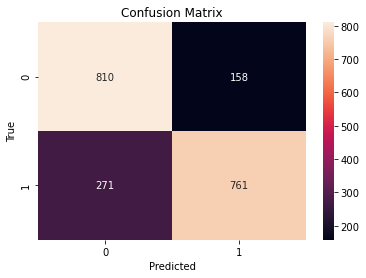

In [20]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='rocket')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

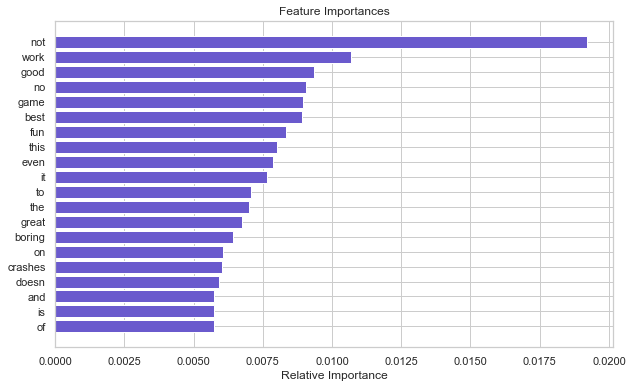

In [49]:
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#6a5acd', align='center')
plt.yticks(range(len(indices)), [tfidf_vectorizer.get_feature_names()[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Precision Recall Curve

In [79]:
y_scores = rf_classifier.predict_proba(X_test)[:, 1]

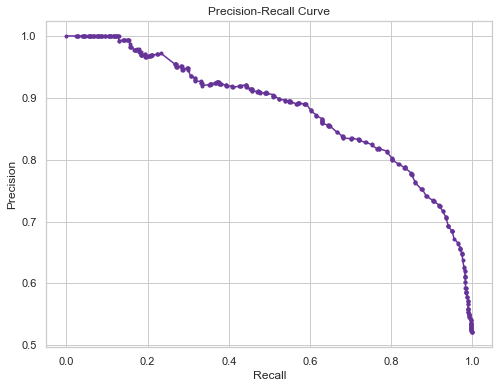

In [80]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='#663399')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

=> small explaination here

In [82]:
auc_score = auc(recall, precision)
print(f'Precision-Recall AUC: {auc_score}')


Precision-Recall AUC: 0.8799852513783057


=> small explaination here

TF-IDF Analysis

=> explaination here 

In [33]:
# creating different dataframes for the respective reviews
positive_reviews_df = reviews_df[reviews_df['sentiment'] == 'positive']
negative_reviews_df = reviews_df[reviews_df['sentiment'] == 'negative']

# transforming the reviews into TF-IDF features
positive_tfidf_matrix = tfidf_vectorizer.transform(positive_reviews_df['review']).toarray()
negative_tfidf_matrix = tfidf_vectorizer.transform(negative_reviews_df['review']).toarray()


In [36]:
# calculating the average TF-IDF scores
avg_tfidf_positive = np.mean(positive_tfidf_matrix, axis=0)
avg_tfidf_negative = np.mean(negative_tfidf_matrix, axis=0)


In [39]:
# getting the feature names
feature_names = tfidf_vectorizer.get_feature_names()

# sorting the indices of the TF-IDF scores
sorted_positive_indices = np.argsort(avg_tfidf_positive)[::-1]
sorted_negative_indices = np.argsort(avg_tfidf_negative)[::-1]

# finding the top terms in both the positive and negative reviews
print("Top terms in positive reviews:")
for i in sorted_positive_indices[:10]:
    print(f"{feature_names[i]}: {avg_tfidf_positive[i]}")

print("\nTop terms in negative reviews:")
for i in sorted_negative_indices[:10]:
    print(f"{feature_names[i]}: {avg_tfidf_negative[i]}")


Top terms in positive reviews:
the: 0.09412228067958306
game: 0.0640602941270284
and: 0.06079703881096361
it: 0.05878144134760082
to: 0.05500309454351725
you: 0.048937804535005874
of: 0.048641739723797144
is: 0.044761070071481286
this: 0.041907087039219124
good: 0.033591654546105965

Top terms in negative reviews:
the: 0.11582991538203863
to: 0.07489748458386736
it: 0.07239349217369909
and: 0.06656360348881726
game: 0.06598038787742491
this: 0.053845376483029096
is: 0.05217466161886408
you: 0.051279826367884696
of: 0.05059671151106563
not: 0.04118870384605657


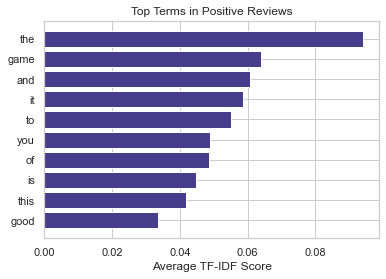

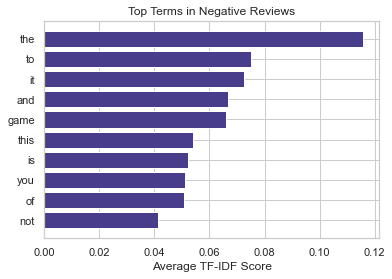

In [54]:
def top_terms(indices, scores, title, num_terms=10, color='#483d8b'):
    terms = [feature_names[i] for i in indices[:num_terms]]
    scores = [scores[i] for i in indices[:num_terms]]
    plt.barh(terms, scores, color=color)
    plt.xlabel('Average TF-IDF Score')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# plotting the top terms in both positive and negative reviews
top_terms(sorted_positive_indices, avg_tfidf_positive, 'Top Terms in Positive Reviews')
top_terms(sorted_negative_indices, avg_tfidf_negative, 'Top Terms in Negative Reviews')


# Delete Later

Questions to answer
- Does the project clearly identify the problem? 
- Does the project clearly describe the relevant data or/and its collection? 
- Does the project clearly explain how the data can be used to draw conclusions about the 
- underlying system? 
- Does the report clearly explain the work that was done? 
- Is the project innovative or novel? 
- Is the model built accurate enough? 
- Does the project use techniques presented in the course (or clearly related to topics covered in the course) to understand and analyze the data for this problem? 
- Does the report explain how this work fits around related work in this subject area? 
- Does the report provide directions for further investigation?